In [1]:
import pandas as pd
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter
from lifelines import utils
from lifelines.plotting import plot_lifetimes 
from lifelines import KaplanMeierFitter
from lifelines.plotting import qq_plot
from lifelines import PiecewiseExponentialFitter
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import statsmodels.api as sm
from lifelines.datasets import load_rossi

In [2]:
df =  pd.read_csv('myeloma.csv')
df

,Time,VStatus,LogBUN,HGB,Platelet,Age,LogWBC,Frac,LogPBM,Protein,SCalc
0,1.25,1,2.2175,9.4,1,67,3.6628,1,1.9542,12,10
1,1.25,1,1.9395,12.0,1,38,3.9868,1,1.9542,20,18
2,2.00,1,1.5185,9.8,1,81,3.8751,1,2.0000,2,15
3,2.00,1,1.7482,11.3,0,75,3.8062,1,1.2553,0,12
4,2.00,1,1.3010,5.1,0,57,3.7243,1,2.0000,3,9
...,...,...,...,...,...,...,...,...,...,...,...
60,28.00,0,1.2304,7.3,1,82,3.7482,1,1.6721,0,9
61,41.00,0,1.7559,12.8,1,72,3.7243,1,1.4472,1,9
62,53.00,0,1.1139,12.0,1,66,3.6128,1,2.0000,1,11
63,57.00,0,1.2553,12.5,1,66,3.9685,0,1.9542,0,11


#### (a).  Please provide a Step Summary table.  The table will show the explanatory variable removed from each step and the variable’s test significance value.

In [3]:
## Create dummy variables
cols=['Time','VStatus','LogBUN','HGB','Platelet','Age','LogWBC','Frac','LogPBM','Protein','SCalc']
df_cox=df[cols]
df = pd.get_dummies(df_cox, drop_first=True)
df.head()

,Time,VStatus,LogBUN,HGB,Platelet,Age,LogWBC,Frac,LogPBM,Protein,SCalc
0,1.25,1,2.2175,9.4,1,67,3.6628,1,1.9542,12,10
1,1.25,1,1.9395,12.0,1,38,3.9868,1,1.9542,20,18
2,2.00,1,1.5185,9.8,1,81,3.8751,1,2.0000,2,15
3,2.00,1,1.7482,11.3,0,75,3.8062,1,1.2553,0,12
4,2.00,1,1.3010,5.1,0,57,3.7243,1,2.0000,3,9


In [4]:
# create indicator variable for Platelet
df['Platelet_indicator'] = (df['Platelet'] == 1).astype(int)

# create indicator variable for Frac
df['Frac_indicator'] = (df['Frac'] == 1).astype(int)

In [5]:
#Removing the feature with the highest P-Value
#Remove Platelet 
cols1=['Time','VStatus','Platelet','LogBUN','HGB','Age','LogWBC','Frac','LogPBM','Protein','SCalc']
df_cox=df[cols1]
cph = CoxPHFitter()   
cph.fit(df_cox, 'Time', event_col='VStatus')   
cph.print_summary()   

<lifelines.CoxPHFitter: fitted with 65 total observations, 17 right-censored observations>
             duration col = 'Time'
                event col = 'VStatus'
      baseline estimation = breslow
   number of observations = 65
number of events observed = 48
   partial log-likelihood = -145.39
         time fit was run = 2023-03-03 22:19:43 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Platelet   -0.25       0.78       0.51            -1.26             0.75                 0.28                 2.11
LogBUN      1.86       6.40       0.66             0.57             3.14                 1.77                23.15
HGB        -0.13       0.88       0.07            -0.27             0.02                 0.77                 1.02
Age        -0.01       0.99       0.02            -0.05             0.03                 0.95                 1.03
LogWBC      0.35       1.42       0.72            -1.05             1.76                 0.35                 5.79
Frac        0.34       1.41       0.41            -0.46             1.14                 0.63                 3.13
LogPBM      0.38       1.46       0.49            -0.57             1.34                 0.56                 3.81
Protein     0.01       1.01       0.03            -0.04             0.06                 0.96                 1.07
SCalc       0.13       1.14       0.11            -0.08             0.34                 0.93                 1.40

            cmp to     z      p   -log2(p)
covariate                                 
Platelet      0.00 -0.50   0.62       0.69
LogBUN        0.00  2.83 <0.005       7.74
HGB           0.00 -1.75   0.08       3.64
Age           0.00 -0.67   0.50       0.99
LogWBC        0.00  0.49   0.62       0.69
Frac          0.00  0.84   0.40       1.32
LogPBM        0.00  0.78   0.43       1.21
Protein       0.00  0.50   0.62       0.69
SCalc         0.00  1.24   0.22       2.21
---
Concordance = 0.68
Partial AIC = 308.77
log-likelihood ratio test = 17.62 on 9 df
-log2(p) of ll-ratio test = 4.65

In [6]:
cph.fit(df_cox, duration_col='Time', event_col='VStatus')

summary_table = []

while cph.summary.sort_values('p', ascending=False).reset_index()['p'][0] > 0.05:
    varname = cph.summary.sort_values('p', ascending=False).reset_index()['covariate'][0]
    pval = cph.summary.sort_values('p', ascending=False).reset_index()['p'][0]
    df_cox = df_cox.drop(varname, axis=1)
    cph.fit(df_cox, duration_col='Time', event_col='VStatus')
    summary_table.append([varname, pval, "Excluded"])

for i in range(0,cph.summary.shape[0]):
    varname = cph.summary.sort_values('p', ascending=False).reset_index()['covariate'][i]
    pval = cph.summary.sort_values('p', ascending=False).reset_index()['p'][i]
    summary_table.append([varname, pval, "Included"])

summary_table = pd.DataFrame(summary_table, columns=['Variable', 'p-value', 'Status'])

summary_table

,Variable,p-value,Status
0,LogWBC,0.621011,Excluded
1,Protein,0.693410,Excluded
2,Platelet,0.656020,Excluded
3,LogPBM,0.452029,Excluded
4,Frac,0.426168,Excluded
5,Age,0.180759,Excluded
6,SCalc,0.173778,Excluded
7,HGB,0.037169,Included
8,LogBUN,0.005534,Included


#### (b)  Please provide a table that shows the explanatory variables included in the final model.  Besides, show these statistics: parameter estimates, standard errors, p-values, Hazard Ratios, and 95% confidence interval for the Hazard Ratios. 

In [7]:
df1 = df_cox.copy()
# Given the above result, the final model after removing\
# insignificant variables contains four variables
df1 = df1[['HGB','LogBUN',  'Time', 'VStatus']]
df1.head()

#Refit the model
cph.fit(df1, duration_col='Time', event_col='VStatus')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 65 total observations, 17 right-censored observations>
             duration col = 'Time'
                event col = 'VStatus'
      baseline estimation = breslow
   number of observations = 65
number of events observed = 48
   partial log-likelihood = -148.06
         time fit was run = 2023-03-03 22:19:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
HGB        -0.12       0.89       0.06            -0.23            -0.01                 0.79                 0.99
LogBUN      1.72       5.56       0.62             0.50             2.93                 1.65                18.70

            cmp to     z    p   -log2(p)
covariate                               
HGB           0.00 -2.08 0.04       4.75
LogBUN        0.00  2.77 0.01       7.50
---
Concordance = 0.67
Partial AIC = 300.12
log-likelihood ratio test = 12.27 on 2 df
-log2(p) of ll-ratio test = 8.85

#### (c) Please plot the baseline hazard for the final model. What is the chance that individuals will experience an event at time 40 given they survive up to 40? (you can use a rough projection on y axis)

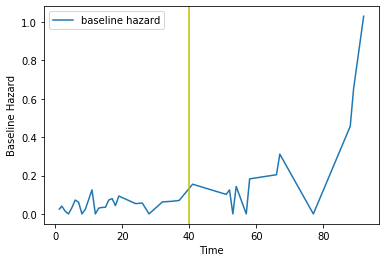

In [8]:
cph.baseline_hazard_.plot()
plt.xlabel('Time')
plt.ylabel('Baseline Hazard')
plt.axvline(x=40, color='y')

From the above baseline hazard plot, we can clearly see that
the chance that individuals will experience an event at time 40 given they survive up to 40 is approximately 0.16

#### (d) Please plot LogBUN partial effects with the values=[0,0.5,1,1.5,2]. Remember, with this exercise, we examine what will the survival curve look like as we vary a single covariate while holding everything else equal.

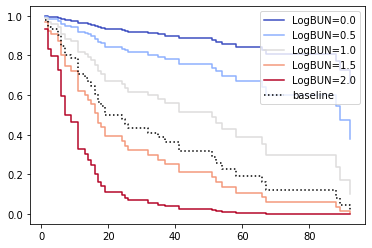

In [9]:
cph.plot_partial_effects_on_outcome('LogBUN',  values=[0, 0.5, 1, 1.5, 2], cmap='coolwarm')
